In [1]:
# 75.06 - 1C202 - TP2 
# Competencia de Machine learning
#
# https://www.kaggle.com/c/nlp-getting-started/overview
#
# Fuentes:
# https://realpython.com/python-keras-text-classification/
# https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

# Importacion de librerias necesarias
import re, string
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLTK
# https://www.nltk.org
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Split y K-Fold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Importacion de Keras
# https://keras.io
from keras.models import Sequential, save_model, load_model
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Configuracion general
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
# Seccion de CONFIGURACION

# Path de entrada
train_path = 'data/processed/train_to_keras.csv'
test_path = 'data/processed/test_to_keras.csv'

# Configuracion del modelo
maxlen = 100
num_filters = 32
kernel_size = 8
embedding_dim = 200
embeddings_path = 'embeddings/glove.twitter.27B.200d.txt'
# Embeddings disponibles en:
# https://worksheets.codalab.org/bundles/0x4090ba96b8a444c2a44b2c47884c25f2

# Configuracion de entrenamiento
num_folds = 10
epochs = 5
verbose = False
batch_size = 10

# Path de para guardar los modelos
model_path = 'models/TP2.Keras.Conv1D.Iter.'

# Path de salida para el submission
submission_path = 'data/submits/submission_Deep_Conv1D_02.csv'

In [3]:
# Funciones AUXILIARES

# Pasa un texto a lowercase
def lowercase_text(text):
    return text.lower()

# Limpia los datos, mediante el uso de expresiones regulares
def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Grafica para un modelo los resultados del entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validación')
    plt.title('Accuracy: validación y entrenamiento')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validación')
    plt.title('Loss: validación y entrenamiento')
    plt.legend()
    plt.show()

# Genera la matriz de embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

# Define el modelo a utilizar, con Conv1D
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hace el fit del modelo, con los parametros proporcionados
def train_model(XTrain, YTrain, epochs, verbose, validation_data, batch_size):
    history = model.fit(XTrain, YTrain,
                        epochs=epochs,
                        verbose=verbose,
                        validation_data=validation_data,
                        batch_size=batch_size)   
    return history

In [5]:
# Carga de los archivos del set de datos

# Set de train: carga, descarte de columnas no utilizadas y limpieza de los textos
df_twitter_train = pd.read_csv(train_path, sep=',')
#df_twitter_train.drop(['keyword','location'], axis=1, inplace=True)
df_twitter_train['text'] = df_twitter_train['text'].apply(lambda x: lowercase_text(x))
df_twitter_train['text'] = df_twitter_train['text'].apply(lambda x: remove_noise(x))

# Set de test: carga, descarte de columnas no utilizadas y limpieza de los textos
df_twitter_test = pd.read_csv(test_path, sep=',')
#df_twitter_test.drop(['keyword','location'], axis=1, inplace=True)
df_twitter_test['text'] = df_twitter_test['text'].apply(lambda x: lowercase_text(x))
df_twitter_test['text'] = df_twitter_test['text'].apply(lambda x: remove_noise(x))

# Nos quedamos con X e y para entrenar
tweets = df_twitter_train['text'].values
y = df_twitter_train['target'].values

# Separamos X para el set de test
tweets_predict = df_twitter_test['text'].values

# Vemos el tamaño de ambos sets
print(df_twitter_train.shape)
print(df_twitter_test.shape)

(7613, 231)
(3263, 230)


In [6]:
# Tratamiento del set con nltk
# Sabiendo que todos los tweets son en idioma ingles, quitamos las stopwords
stop_words = set(stopwords.words('english'))
df_twitter_train['text'] =  df_twitter_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_twitter_test['text'] =  df_twitter_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Lematizamos los textos de los tweets
lem = WordNetLemmatizer()
df_twitter_train['text'] =  df_twitter_train['text'].apply(lambda x: ' '.join([lem.lemmatize(word,"v") for word in x.split()]))
df_twitter_test['text'] =  df_twitter_test['text'].apply(lambda x: ' '.join([lem.lemmatize(word,"v") for word in x.split()]))

In [7]:
# Vemos como quedo el set de train
df_twitter_train.head()

,id,text,target,length,totalwords,hashtagsCantidad,preguntas,simbolos,conUbicacion,conKeyword,...,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,1,deeds reason earthquake may allah forgive us,1,69,13,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,4,forest fire near la ronge sask canada,1,38,7,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,5,residents ask shelter place notify officer eva...,1,133,22,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,6,people receive wildfires evacuation order cali...,1,65,8,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,7,get send photo ruby alaska smoke wildfires pou...,1,88,16,2,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Vemos como quedo el set de test
df_twitter_test.head()

,id,text,length,totalwords,hashtagsCantidad,preguntas,simbolos,conUbicacion,conKeyword,ablaze,...,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,0,happen terrible car crash,34,6,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,hear earthquake different cities stay safe eve...,64,9,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,forest fire spot pond geese flee across street...,96,19,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9,apocalypse light spokane wildfires,40,4,2,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,11,typhoon soudelor kill china taiwan,45,8,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Tokenizamos los textos
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)

# Convertimos a secuencias
X = tokenizer.texts_to_sequences(tweets)
X_predict = tokenizer.texts_to_sequences(tweets_predict)

# Calculamos el tamaño
vocab_size = len(tokenizer.word_index) + 1  # 0 es un indice reservado, sumamos 1

In [10]:
# Paddeamos a maxlen
X = pad_sequences(X, padding='post', maxlen=maxlen)
X_predict = pad_sequences(X_predict, padding='post', maxlen=maxlen)

In [18]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path): 
    with open(path,'r', encoding='UTF-8') as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

SyntaxError: invalid syntax (<ipython-input-18-58961a0941d8>, line 6)

In [19]:
# Generacion de la matriz de embeddings
embedding_matrix = create_embedding_matrix(embeddings_path,tokenizer.word_index, embedding_dim)

# Vemos que cobertura tenemos con los embeddings utilizados
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Cobertura de vocabulario: ' + str(nonzero_elements / vocab_size))

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 440: character maps to <undefined>

------------------------------------------------------------------------
Entranando, fold 1...
Puntaje de entrenamiento para el fold 1: loss de 0.07348567247390747; accuracy de 97.64997959136963%
Puntaje de validación para el fold 1: loss de 0.8115034103393555; accuracy de 78.47769260406494%


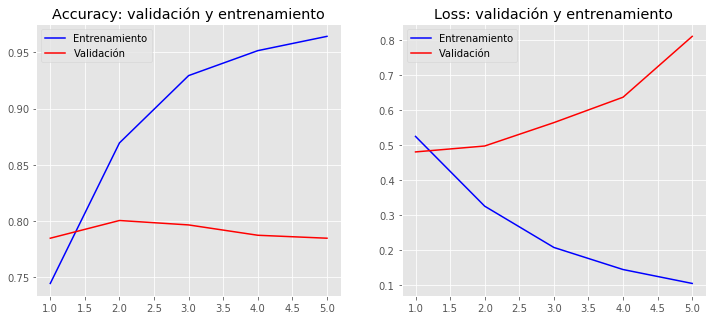

------------------------------------------------------------------------
Entranando, fold 2...
Puntaje de entrenamiento para el fold 2: loss de 0.05119626969099045; accuracy de 97.51861095428467%
Puntaje de validación para el fold 2: loss de 0.8514397740364075; accuracy de 77.95275449752808%


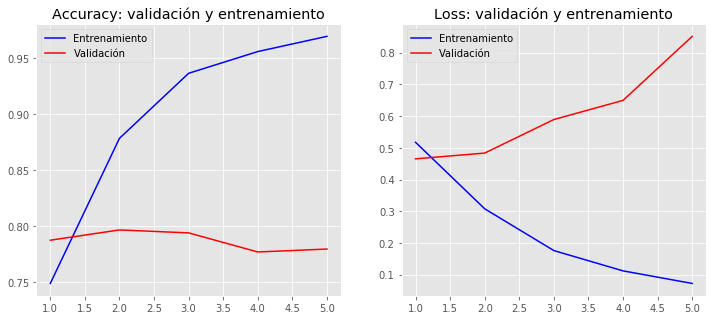

------------------------------------------------------------------------
Entranando, fold 3...
Puntaje de entrenamiento para el fold 3: loss de 0.06299170851707458; accuracy de 97.53320813179016%
Puntaje de validación para el fold 3: loss de 0.7766767740249634; accuracy de 76.64042115211487%


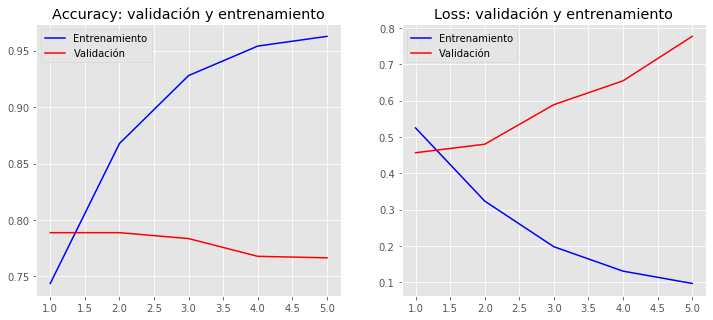

------------------------------------------------------------------------
Entranando, fold 4...
Puntaje de entrenamiento para el fold 4: loss de 0.05934494733810425; accuracy de 97.62113094329834%
Puntaje de validación para el fold 4: loss de 0.8100599646568298; accuracy de 75.29566287994385%


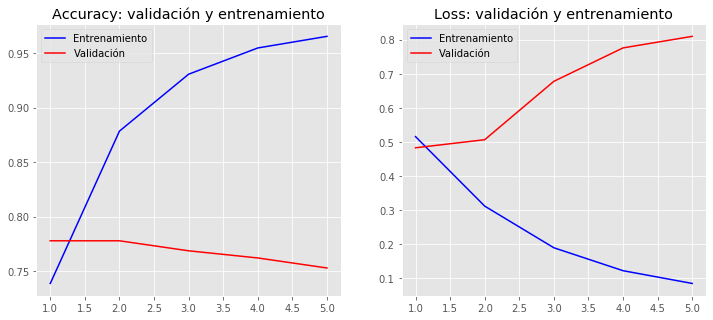

------------------------------------------------------------------------
Entranando, fold 5...
Puntaje de entrenamiento para el fold 5: loss de 0.05493483319878578; accuracy de 97.53356575965881%
Puntaje de validación para el fold 5: loss de 0.7971635460853577; accuracy de 77.79237627983093%


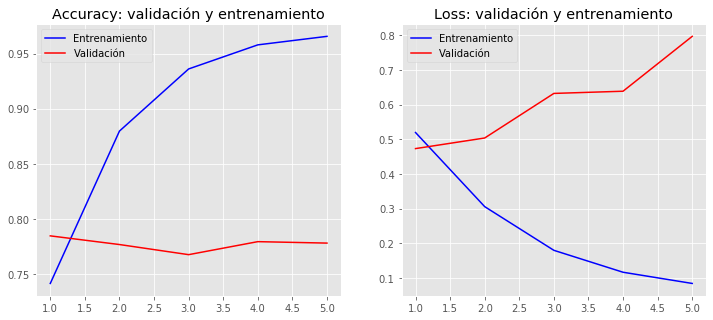

------------------------------------------------------------------------
Entranando, fold 6...
Puntaje de entrenamiento para el fold 6: loss de 0.07775529474020004; accuracy de 97.32924699783325%
Puntaje de validación para el fold 6: loss de 0.6647078394889832; accuracy de 77.52956748008728%


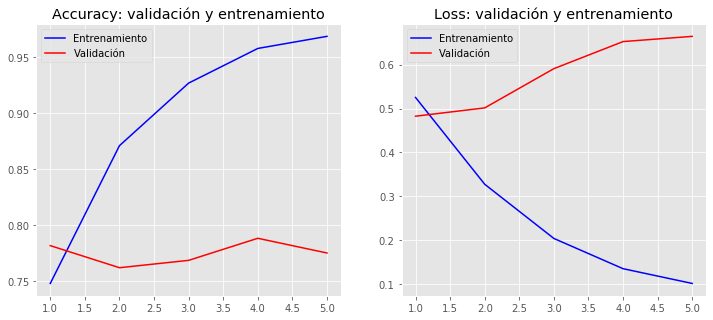

------------------------------------------------------------------------
Entranando, fold 7...
Puntaje de entrenamiento para el fold 7: loss de 0.0639999657869339; accuracy de 97.72329330444336%
Puntaje de validación para el fold 7: loss de 0.8218890428543091; accuracy de 75.16425848007202%


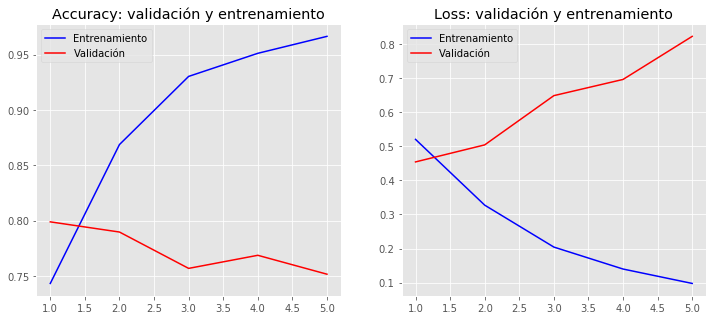

------------------------------------------------------------------------
Entranando, fold 8...
Puntaje de entrenamiento para el fold 8: loss de 0.06136592850089073; accuracy de 97.63572812080383%
Puntaje de validación para el fold 8: loss de 0.6764954924583435; accuracy de 79.36925292015076%


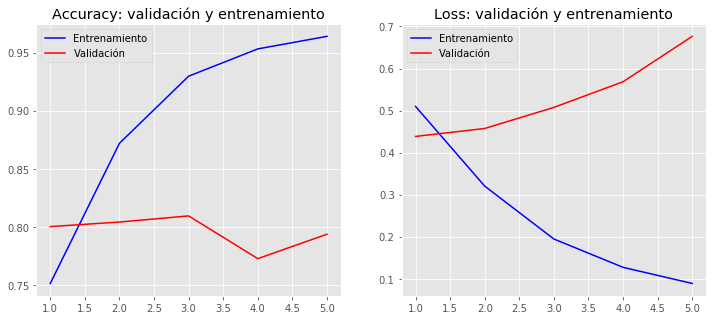

------------------------------------------------------------------------
Entranando, fold 9...
Puntaje de entrenamiento para el fold 9: loss de 0.060094401240348816; accuracy de 97.70869612693787%
Puntaje de validación para el fold 9: loss de 0.7569838166236877; accuracy de 76.60972476005554%


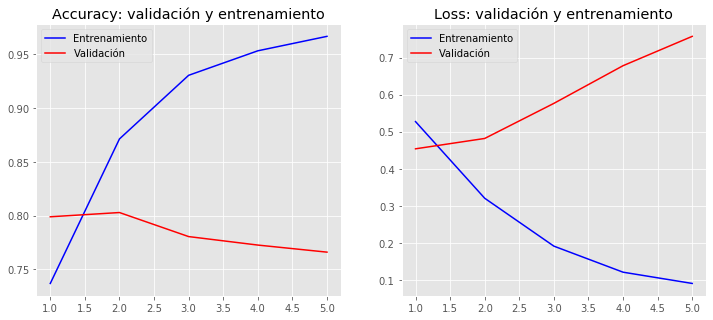

------------------------------------------------------------------------
Entranando, fold 10...
Puntaje de entrenamiento para el fold 10: loss de 0.05803592503070831; accuracy de 97.48978614807129%
Puntaje de validación para el fold 10: loss de 0.7281997203826904; accuracy de 79.10643815994263%


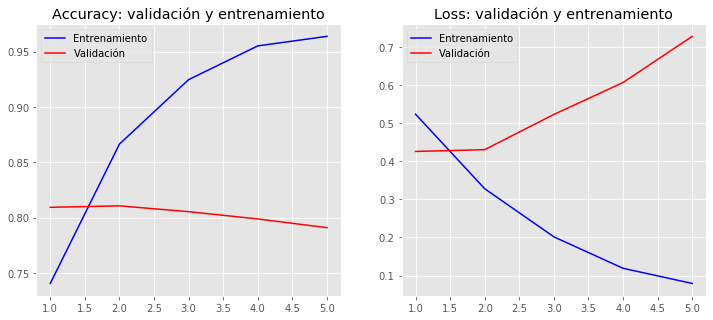



Puntaje promedio de entrenamiendo, para todos los folds:
> Accuracy: 97.57432460784912 (+- 0.11207047974179545)
> Loss: 0.062320494651794435


Puntaje promedio de validación, para todos los folds:
> Accuracy: 77.39381492137909 (+- 1.3804159266438134)
> Loss: 0.7695119380950928
------------------------------------------------------------------------


In [11]:
# Definimos y entrenamos el modelo
# K-Fold Cross Validation

# Definimos los arrays para guardar los resultados
# Train
acc_per_fold_train = []
loss_per_fold_train = []
# Validacion
acc_per_fold_validation = []
loss_per_fold_validation = []

# Definomos el K-fold Cross Validator a usar
kfold = KFold(n_splits=num_folds, shuffle=True)

# Hacemos el bucle para la cantidad de folds definidos
fold_no = 1
for train, validation in kfold.split(X, y):

    # Imprimimos el progreso
    print('------------------------------------------------------------------------')
    print(f'Entranando, fold {fold_no}...')

    # Definimos la arquitectura del modelo
    model = create_model(num_filters=num_filters,
                         kernel_size=kernel_size,
                         vocab_size=vocab_size,
                         embedding_dim=embedding_dim,
                         maxlen=maxlen)

    # Hacemos el fit
    history = train_model(X[train], y[train],
                        epochs=epochs,
                        verbose=verbose,
                        validation_data = (X[validation], y[validation]),
                        batch_size=batch_size)

    # Generamos la metrica de entrenamiento
    scores_train = model.evaluate(X[train], y[train], verbose=0)
    print(f'Puntaje de entrenamiento para el fold {fold_no}: {model.metrics_names[0]} de {scores_train[0]}; {model.metrics_names[1]} de {scores_train[1]*100}%')
    acc_per_fold_train.append(scores_train[1] * 100)
    loss_per_fold_train.append(scores_train[0])
    
    # Generamos la metrica de test
    scores_validation = model.evaluate(X[validation], y[validation], verbose=0)
    print(f'Puntaje de validación para el fold {fold_no}: {model.metrics_names[0]} de {scores_validation[0]}; {model.metrics_names[1]} de {scores_validation[1]*100}%')
    acc_per_fold_validation.append(scores_validation[1] * 100)
    loss_per_fold_validation.append(scores_validation[0])
    
    # Guardamos el modelo
    save_model(model, model_path + str(fold_no) + '.h5', save_format='h5')
    
    # Plotteamos el resultado final
    plot_history(history)
    
    # Incrementamos el fold
    fold_no = fold_no + 1
    
print('\n')
print('Puntaje promedio de entrenamiendo, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_train)} (+- {np.std(acc_per_fold_train)})')
print(f'> Loss: {np.mean(loss_per_fold_train)}')
print('\n')
print('Puntaje promedio de validación, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_validation)} (+- {np.std(acc_per_fold_validation)})')
print(f'> Loss: {np.mean(loss_per_fold_validation)}')
print('------------------------------------------------------------------------')

In [19]:
# Cargamos el modelo con el mejor puntaje
filepath = model_path + str(8) + '.h5'
loaded_model = load_model(filepath, custom_objects=None, compile=True)

# Imprimimos el detalle del modelo utilizado
loaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 200)          2966400   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 93, 32)            51232     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 3,017,973
Trainable params: 3,017,973
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Prediccion en base al modelo entrenado
# Esto esta deprecado!
# y_predict = model.predict_classes(X_predict)

# Segun la docu se hace asi:
y_predict = (loaded_model.predict(X_predict) > 0.5).astype('int32')

In [14]:
# Generacion del dataframe que generara el submit para la competencia
kaggle_submission = pd.DataFrame(df_twitter_test,columns = ['id'])
kaggle_submission['target'] = y_predict
kaggle_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [15]:
# Escritura del submit en formato CSV
kaggle_submission.to_csv(submission_path, index=False)

In [16]:
# ToDo:
# Grid search, busqueda de hiper-parametros ideales